In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [53]:
DATA_HUB = {}
DATA_PATH = './data/house-prices-advanced-regression-techniques'

In [54]:
train_data = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [55]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [56]:
train_data.iloc[0:4, [0, 1, 2, 3, 4, -3, -2, -1]], test_data.iloc[0:4, [0, 1, 2, 3, 4, -3, -2, -1]]

(   Id  MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition  \
 0   1          60       RL         65.0     8450       WD        Normal   
 1   2          20       RL         80.0     9600       WD        Normal   
 2   3          60       RL         68.0    11250       WD        Normal   
 3   4          70       RL         60.0     9550       WD       Abnorml   
 
    SalePrice  
 0     208500  
 1     181500  
 2     223500  
 3     140000  ,
      Id  MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType  \
 0  1461          20       RH         80.0    11622    2010       WD   
 1  1462          20       RL         81.0    14267    2010       WD   
 2  1463          60       RL         74.0    13830    2010       WD   
 3  1464          60       RL         78.0     9978    2010       WD   
 
   SaleCondition  
 0        Normal  
 1        Normal  
 2        Normal  
 3        Normal  )

In [57]:
# 在每个样本中，第一个特征是ID，ID与数据没有关联，我们将其从数据集中删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.iloc[[0, 1, 2, 3, 1460, 1461, 1462, 1463], [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml
0,20,RH,80.0,11622,2010,WD,Normal
1,20,RL,81.0,14267,2010,WD,Normal
2,60,RL,74.0,13830,2010,WD,Normal
3,60,RL,78.0,9978,2010,WD,Normal


In [58]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features, all_features.dtypes

(Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'],
       dtype='object'),
 MSSubClass         int64
 MSZoning          object
 LotFrontage      float64
 LotArea            int64
 Street            object
                   ...   
 MiscVal            int64
 MoSold             int64
 YrSold             int64
 SaleType          object
 SaleCondition     object
 Length: 79, dtype: object)

In [59]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [60]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [61]:
n_train = train_data.shape[0]
train_features = d2l.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = d2l.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = d2l.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

In [62]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [63]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [64]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [65]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = d2l.concat([X_train, X_part], 0)
            y_train = d2l.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [66]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169825, 验证log rmse0.156517
折2，训练log rmse0.162195, 验证log rmse0.189696
折3，训练log rmse0.163766, 验证log rmse0.168509
折4，训练log rmse0.168355, 验证log rmse0.154361
折5，训练log rmse0.163335, 验证log rmse0.183134
5-折验证: 平均训练log rmse: 0.165495, 平均验证log rmse: 0.170443


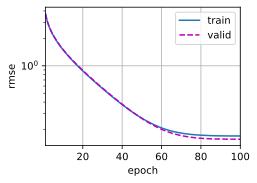

In [67]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')